In [1]:
import kagglehub
import os
from typing import Literal

from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
# from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

import segmentation_models_pytorch as smp
from tqdm import tqdm

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {device}")

Device: mps


In [2]:

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")
path = os.path.join(path, "Data")
print("Path to dataset files:", path)

Path to dataset files: /Users/dami/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1/Data


In [3]:
print(f"Number of samples in train set: {len(os.listdir(os.path.join(path, 'Train', 'image')))}")
print(f"Number of samples in test set : {len(os.listdir(os.path.join(path, 'Test', 'image')))}")

Number of samples in train set: 80
Number of samples in test set : 20


In [8]:
try:
    idx = 5
    I = np.array(Image.open(os.path.join(path, "Train", "image", f"{idx}.png")))
    mask = np.array(Image.open(os.path.join(path, "Train", "mask", f"{idx}.png")))
except FileNotFoundError as e:
    print(e)

mask.shape


(512, 512)

In [9]:
I = np.array(I)

In [10]:
class NormalizeToIndex():
    def __init__(self, treshold: float = 0.5):
        self.treshold = treshold

    def __call__(self, y: torch.Tensor):
        return torch.where(y > self.treshold, 1, 0)

In [11]:

unet_size = 512


class ImageDataSet(Dataset):
    def __init__(self, directory_path=os.path.join(path, "Train"), n_samples=80, sample_transform=None,
                 target_transform=None):
        super(ImageDataSet, self).__init__()
        self.X_transform = sample_transform
        self.Y_transform = target_transform
        self.X = []
        self.Y = []

        for i in range(n_samples):
            try:
                image_path = os.path.join(directory_path, "image", f"{i}.png")
                mask_path = os.path.join(directory_path, "mask", f"{i}.png")
                image = self._load_transform_(image_path, target=False)
                mask = self._load_transform_(mask_path, target=True)
            except Exception as e:
                print(e)
                continue
            self.X.append(image)
            self.Y.append(mask)
        self.X = torch.stack(self.X)
        self.Y = torch.stack(self.Y)

    def _load_transform_(self, path, target=False):
        image = np.array(Image.open(path))
        if not target:
            return self.X_transform(image) if self.X_transform else image
        else:
            return self.Y_transform(image) if self.Y_transform else image

    def __getitem__(self, idx):
        # print(self.Y[idx].size())
        return (self.X[idx], self.Y[idx])

    def __len__(self):
        return len(self.X)


train_dataset = ImageDataSet(
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
        # NormalizeToBool(treshold=0.5)
    ]))


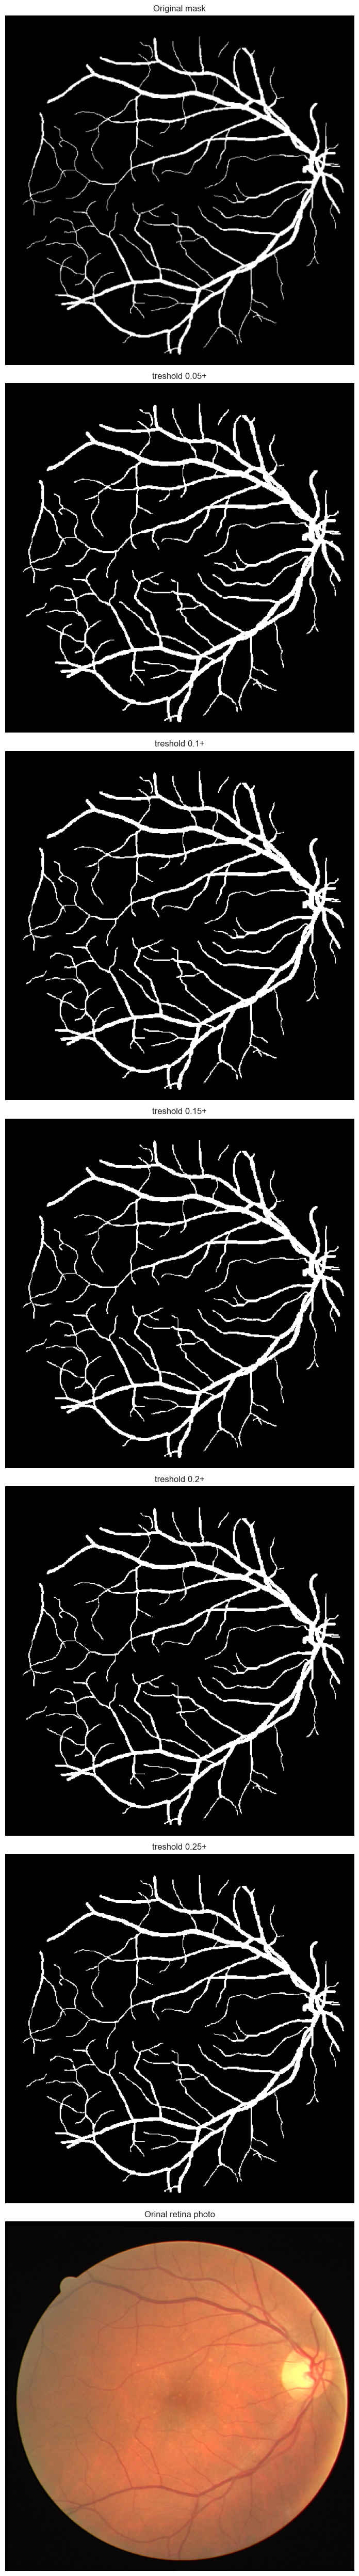

In [12]:
idx = 1
c = train_dataset.__getitem__(idx)[1].squeeze()
# c = a.__getitem__(1)[1].squeeze()
# resize = transforms.Resize([224])
# c = resize(torch.Tensor(c).unsqueeze(dim = 0)).squeeze()

fig, ax = plt.subplots(7, 1, figsize=(100, 50))
plt.gray()

ax[0].imshow(c)
ax[0].set_title("Original mask")

ax[1].imshow(c > 0.05)
ax[1].set_title("treshold 0.05+")

ax[2].imshow(c > 0.1)
ax[2].set_title("treshold 0.1+")
ax[3].imshow(c > 0.15)
ax[3].set_title("treshold 0.15+")
ax[4].imshow(c > 0.2)
ax[4].set_title("treshold 0.2+")
ax[5].imshow(c > 0.25)
ax[5].set_title("treshold 0.25+")

ax[6].imshow(train_dataset.__getitem__(idx)[0].permute(1, 2, 0))
ax[6].set_title("Orinal retina photo")
[a.set_axis_off() for a in ax]
plt.tight_layout()
plt.show()



So probably the best treshold will be 0.15

In [13]:
train_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Train"),
    n_samples=80,
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15)
    ]))

test_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Test"),
    n_samples=20,
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15)
    ]))

In [14]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [18]:
unet = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
    # activation="sigmoid"
)

In [22]:
def train(model=unet, train_loader=train_loader, val_loader=test_loader, lr=1e-3, EPOCHS=10):
    model.to(device)
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
    criterion = smp.losses.JaccardLoss(mode="binary", from_logits=True) #this is IoU_loss
    sigmoid = nn.Sigmoid()

    iou_metric = MeanIoU(num_classes=2, input_format="index", include_background=False).to(device)
    dice_metric = DiceScore(num_classes=2, input_format="index", include_background=False).to(device)
    train_iou_scores = []
    test_iou_scores = []
    train_dice_scores = []
    test_dice_scores = []
    print("Start training:")
    for i in tqdm(range(EPOCHS)):
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()

            Y_pred = (sigmoid(Y_pred) > 0.5).to(int)
            iou_metric.update(Y_pred, Y)
            dice_metric.update(Y_pred, Y)
        train_iou_scores.append(iou_metric.compute().item())
        train_dice_scores.append(dice_metric.compute().item())
        iou_metric.reset()
        dice_metric.reset()




        model.eval()
        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                Y_pred = (sigmoid(model(X)) > 0.5).to(int)

                iou_metric.update(Y_pred, Y)
                dice_metric.update(Y_pred, Y)

            test_iou_scores.append(iou_metric.compute().item())
            test_dice_scores.append(dice_metric.compute().item())
            iou_metric.reset()
            dice_metric.reset()


        # I dont print loss, because score = 1 - loss, do it is the SAME

        print(f"Epoch: {str(i + 1).zfill(2)} | Train_IoU_score: {train_iou_scores[-1]:.4f}, Test_IoU_score: {test_iou_scores[-1]:.4f} | Train_f1_score: {train_dice_scores[-1]:.4f}, Test_f1_score: {test_dice_scores[-1]:.4f}")

    return train_iou_scores, train_dice_scores, test_iou_scores, test_dice_scores

train_iou_scores, train_f1_scores, test_iou_scores, test_f1_scores = train(EPOCHS=35)

Start training:


 10%|█         | 1/10 [00:44<06:44, 44.99s/it]

Epoch: 01 | Train_IoU_score: 0.6241, Test_IoU_score: 0.6587 | Train_f1_score: 0.7637, Test_f1_score: 0.7912


 20%|██        | 2/10 [01:39<06:46, 50.84s/it]

Epoch: 02 | Train_IoU_score: 0.6800, Test_IoU_score: 0.6126 | Train_f1_score: 0.8091, Test_f1_score: 0.7635


 30%|███       | 3/10 [02:07<04:41, 40.22s/it]

Epoch: 03 | Train_IoU_score: 0.6948, Test_IoU_score: 0.6809 | Train_f1_score: 0.8196, Test_f1_score: 0.8008


 40%|████      | 4/10 [02:34<03:29, 34.89s/it]

Epoch: 04 | Train_IoU_score: 0.7039, Test_IoU_score: 0.6799 | Train_f1_score: 0.8259, Test_f1_score: 0.8037


 50%|█████     | 5/10 [02:53<02:26, 29.27s/it]

Epoch: 05 | Train_IoU_score: 0.7087, Test_IoU_score: 0.6935 | Train_f1_score: 0.8292, Test_f1_score: 0.8134


 60%|██████    | 6/10 [03:19<01:52, 28.16s/it]

Epoch: 06 | Train_IoU_score: 0.7136, Test_IoU_score: 0.6934 | Train_f1_score: 0.8325, Test_f1_score: 0.8134


 70%|███████   | 7/10 [03:36<01:13, 24.54s/it]

Epoch: 07 | Train_IoU_score: 0.7192, Test_IoU_score: 0.6889 | Train_f1_score: 0.8364, Test_f1_score: 0.8101


 80%|████████  | 8/10 [03:53<00:44, 22.25s/it]

Epoch: 08 | Train_IoU_score: 0.7213, Test_IoU_score: 0.6974 | Train_f1_score: 0.8377, Test_f1_score: 0.8167


 90%|█████████ | 9/10 [04:10<00:20, 20.31s/it]

Epoch: 09 | Train_IoU_score: 0.7253, Test_IoU_score: 0.6937 | Train_f1_score: 0.8405, Test_f1_score: 0.8171


100%|██████████| 10/10 [04:26<00:00, 26.69s/it]

Epoch: 10 | Train_IoU_score: 0.7274, Test_IoU_score: 0.6947 | Train_f1_score: 0.8419, Test_f1_score: 0.8153


[0.30090898275375366, 0.773123562335968]

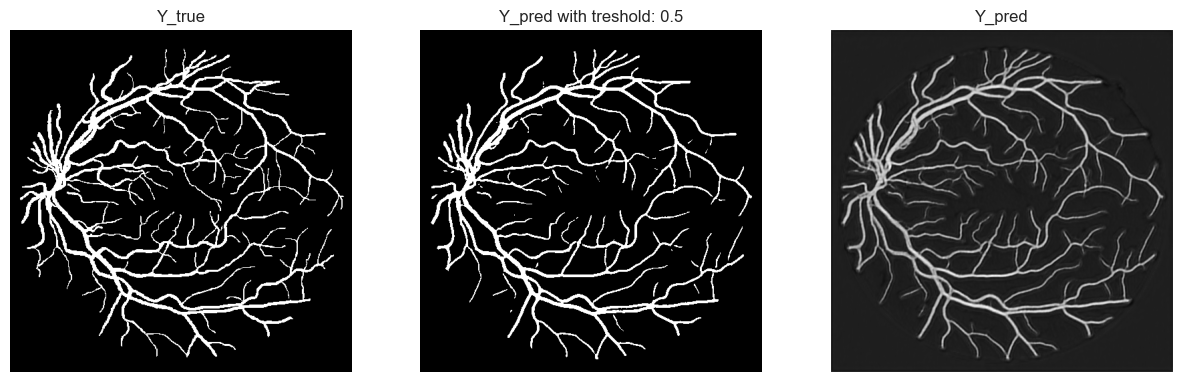

In [21]:
idx = 0
treshold = 0.5
unet.to("cpu")

with torch.no_grad():
    unet.eval()

    image = test_dataset.__getitem__(idx)[0]
    mask = test_dataset.__getitem__(idx)[1].squeeze()

    mask_pred = unet(image.unsqueeze(0))
    # print((mask_pred > treshold).)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    ax[0].imshow(mask.squeeze())
    ax[0].set_title("Y_true")
    ax[1].imshow((mask_pred.squeeze() > treshold).to(int))
    ax[1].set_title(f"Y_pred with treshold: {treshold}")
    ax[2].imshow(mask_pred.squeeze())
    ax[2].set_title("Y_pred")

    for a in ax:
        a.set_axis_off()
    plt.show()


Brudnopis: